![terrainbento logo](../images/terrainbento_logo.png)


# Introduction to the terrainbento `OutputWriters`.


## Overview
This tutorials shows example usage of the terrainbento boundary handlers. For comprehensive information about all options and defaults, refer to the [documentation](http://terrainbento.readthedocs.io/en/latest/). 

## Prerequisites
This tutorial assumes you have at least skimmed the [terrainbento manuscript]() and worked through the [Introduction to terrainbento](http://localhost:8888/notebooks/example_usage/Introduction_to_terrainbento.ipynb) tutorial. **The manuscript link is not yet active**. 


### terrainbento `OutputWriters`

By default terrainbento will save a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file at equal intervals specified by the ``output_interval`` parameter. Many applications may find it sufficient to run a model, save output, and then open the stack of NetCDFs for postprocessing (we recommend [xarray](http://xarray.pydata.org/en/stable/) and [holoviews](http://holoviews.org) for opening, analyzing, and plotting stacks of NetCDFs in python). 

If in your application, you want to have additional output written at the ``output_interval`` intervals, you can pass any number of functions or classes that write this ouput to terrainbento. These functions and classes are called **`OutputWriters`**. There is no limit to what you can do with the `OutputWriters`. You could use them to make plots to turn into an animation, write diagnostic information about model run time, or calculate an objective function value over time. 

To make the `OutputWriters` support as many possible use cases, terrainbento was designed to take any number of functions or classes as `OutputWriters`. 

### Reference material
If you are not familiar with user defined python functions, consider reviewing [this tutorial](https://www.datacamp.com/community/tutorials/functions-python-tutorial#udf). If you are not familiar with user defined python classes, consider referring to [this tutorial](https://www.digitalocean.com/community/tutorials/how-to-construct-classes-and-define-objects-in-python-3).


### Example Usage

To begin, we will import the required python modules. 

In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from landlab.components import DrainageDensity
from landlab import imshow_grid

from terrainbento import Basic

We begin by creating an example user defiend `OutputWriter` function. When a terrainbento model runs the `OutputWriter` function, it will pass the model instance to the `OuputWriter`. Thus the `OutputWriter` function must be able to make all required calculations and plots based on the model instance. It is almost always the case that a user will want to write some sort of output -- typically a text file or plot -- each time the `OutputWriter` is run. 

A user has the option of appending the `OutputWriter` output to a file or using the model attributes `model.model_time` or `model.iteration` in the output file name to distinguish it from other files.  



In [2]:
def name_of_output_writer_function(model):
    # put lines of code here that use the model object to calculate outputs 
    # for example, mean elevation
    val = model.z.mean()
    
    # write output, option 1: unique files per timestep
    with open('name_of_file.' + str(int(model.iteration)) + '.txt', 'w') as f:
        f.write(str(val))
    
    # write output, option 2: append values to same file
    with open('name_of_file.txt', 'a') as f:
        f.write(str(model.iteration) + ', ' + str(model.model_time) + ', ' + str(val) + '\n')


Here we will define an output writer called `write_drainage_density`. Not surprisingly, it calculates and writes out the drainage density of a model domain. The **DrainageDensity** component has two options for identifying where channels are located -- either a user specified channel mask or a slope-area threshold. We will use this latter option. 

In [3]:
def write_drainage_density(model):
    dd = DrainageDensity(model.grid, 
                         area_coefficient=0.1,
                         slope_coefficient=1.0, 
                         area_exponent=0.5,
                         slope_exponent=0.6, 
                         channelization_threshold=0.35)
    mean_drainage_density = dd.calc_drainage_density() 
    fname = 'drainage_density.txt'
    if os.path.exists(fname) is False:
        with open(fname, 'w') as f:
            f.write('model_time,drainage_density\n')
    
    with open(fname, 'a') as f:
        f.write(str(model.model_time) + ', ' + str(mean_drainage_density) + '\n')
    
    del dd

Next we construct the parameter dictionary we will use to run the model. 

In [4]:
basic_params = {# these three parameters are required by all models
          'dt' : 500, # years
          'output_interval': 1e3, # years
          'run_duration': 5e5, # years
          # these parameters are needed to specify the details of the model 
          # grid, by default a raster model grid is created
          'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0, # meters  
          "add_random_noise": True, 
          "initial_noise_std": 1.,
          "initial_elevation": 5.,
          'random_seed': 4897, # set to initialize the topography with reproducible random noise
          # these parameter control geomorphic processes
          'water_erodability' : 0.001, # years^-1
          'm_sp' : 0.5, # unitless
          'n_sp' : 1.0, # unitless
          'regolith_transport_parameter' : 0.1, # meters^2/year
          # these parameters control model boundary conditions
          "BoundaryHandlers": "NotCoreNodeBaselevelHandler",
          "NotCoreNodeBaselevelHandler": {"modify_core_nodes": True, "lowering_rate": -0.0005} , # meters/year
          # these parameter control how model output is written
          'save_first_timestep': True,
          'output_filename': 'example_output_writer',
         }

Unline the `BoundaryHandlers` described in [this tutorial](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb) we pass the `OutputWriters` to terrainbento as a keyword argument. 

After instantiating the model, we run it. 

In [5]:
basic = Basic(params=basic_params, OutputWriters=write_drainage_density)
basic.run(output_fields='topographic__elevation')

First we will make a plot of the topography. We have evolved some nice valleys and ridges. 

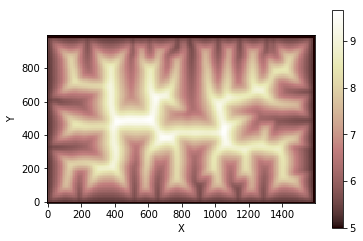

In [6]:
imshow_grid(basic.grid, basic.z)

Next we plot the channel mask from the last timestep. It is stored in an at-node grid field called `chanel__mask`.

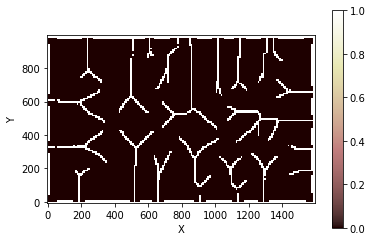

In [7]:
imshow_grid(basic.grid, 'channel__mask')

Our mask identifies the channel areas. 

Next we will read in the output we wrote to the file `drainage_density.txt` using [pandas](https://pandas.pydata.org) and remove the files created by running the model. In your usage you probably won't want to remove these files, but we are doing it so that running the model won't create lots of files in your directory. 

In [8]:
df = pd.read_csv('drainage_density.txt')
basic.remove_output_netcdfs()
os.remove('drainage_density.txt')

We can look at what is inside of the dataframe. 

In [9]:
df
df.columns

Index(['model_time', 'drainage_density'], dtype='object')

This dataframe shows us the history of drainage density through time. Next we will plot it. 

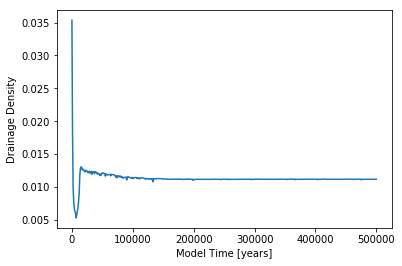

In [10]:
plt.figure()
plt.plot(df.model_time, df.drainage_density)
plt.xlabel('Model Time [years]')
plt.ylabel('Drainage Density')
plt.show()

### Using a class instead of a function

terrainbento can support `OutputWriter` classes. It is expected that the class will look something like the following.

In [11]:
class my_ouput_writer_class(object):
    def __init__(self, model):
        # save the model to the output writer class
        self.model = model
        # do whatever else you want to do here:
    def run_one_step(self):
        # make calculations
        
        # write something out based on the calculations. 
        # we recommend including the model time as a part of
        # the filename so that it is possible to identify
        # what time each file is associated with
        
        pass # remove this line when you modify this example. 
        

You might ask: when is an `OutputWriter` class more appropriate than a function? The answer is that if you can calculate everything you need from the model instance at a given timestep, you probably can just use a function. However, if you need information from past timesteps, you'll need to use a class. 

For example, here we will use a simple example in which the `OutputWriter` writes out the mean and maximum elevation averaged over a few timesteps. We could not do this with a function. 

In [12]:
class time_averaged_elevation(object):
    def __init__(self, model):
        self.model = model
        self.model_time = []
        self.model_mean_elevation = []
        self.model_max_elevation = []
    def run_one_step(self):
        self.model_time.append(self.model.model_time)
        self.model_mean_elevation.append(self.model.z[self.model.grid.core_nodes].mean())
        self.model_max_elevation.append(self.model.z[self.model.grid.core_nodes].max())
        if len(self.model_time)>=5:
            with open('time_averaged_elevation.' + str(int(self.model.model_time)) + '.txt', 'w') as f:
                f.write(str(np.mean(self.model_mean_elevation[-5:])) + '\n')
                f.write(str(np.mean(self.model_max_elevation[-5:])) + '\n')

Next we run the model with the new `OutputWriter`. Note that if you want to use more than one `OutputWriter` you can just provide a list of functions and classes. 

In [13]:
basic = Basic(params=basic_params, OutputWriters=[time_averaged_elevation, write_drainage_density])
basic.run(output_fields='topographic__elevation')

Now that we've run the model we will compile all of the output into a dataframe and plot it. 

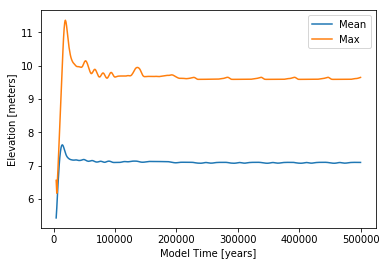

In [14]:
output_files = glob.glob('time_averaged_elevation.*.txt')
temp = {}
for of in output_files:
    with open(of, 'r') as f:
        model_time = int(of.split('.')[-2])
        mean_elev = float(f.readline())
        max_elev = float(f.readline())
        temp[model_time] = {'mean_elevation': mean_elev, 
                            "max_elevation": max_elev}
    os.remove(of)
df = pd.DataFrame(temp).T

basic.remove_output_netcdfs()
os.remove('drainage_density.txt')
    
plt.figure()
plt.plot(df.index, df.mean_elevation, label='Mean')
plt.plot(df.index, df.max_elevation, label='Max')
plt.legend()
plt.xlabel('Model Time [years]')
plt.ylabel('Elevation [meters]')
plt.show()

## Next Steps

- We recommend you review the [terrainbento manuscript](). **Link not yet active**

- There are three additional introductory tutorials: 

    1) [Introduction terrainbento](http://localhost:8888/notebooks/example_usage/Introduction_to_terrainbento.ipynb) 
    
    2) [Introduction to boundary conditions in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb)
    
    3) **This Notebook**: [Introduction to OutputWriters in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_output_writers.ipynb). 
    
    
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:

    1) [Basic](http://localhost:8888/notebooks/coupled_process_elements/model_000_COUPLED_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

    2) [BasicVm](http://localhost:8888/notebooks/coupled_process_elements/model_001_COUPLED_steady_solution.ipynb) which permits the drainage area exponent to change.

    3) [BasicCh](http://localhost:8888/notebooks/coupled_process_elements/model_040_COUPLED_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law.

    4) [BasicVs](http://localhost:8888/notebooks/coupled_process_elements/model_200_COUPLED_steady_solution.ipynb) which uses variable source area hydrology.

    5) [BasisRt](http://localhost:8888/notebooks/coupled_process_elements/model_800_COUPLED_steady_solution.ipynb) which allows for two lithologies with different K values.